In [ ]:
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from homography import Homography
os.environ["TORCHDYNAMO_DISABLE"] = "1"

In [2]:
config_path = Path("outputs/stata_office/f3rm/2025-04-03_050224/config.yml")
eval_idx = 0
cfg, pipeline, _, _ = eval_setup(config_path=config_path)
model = pipeline.model
cameras = pipeline.datamanager.eval_dataset.cameras
camera_ray_bundle = cameras.generate_rays(camera_indices=eval_idx).to(model.device)
outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

[14:12:30] Auto image downscale factor of 2                                                 ]8;id=278889;file:///home/dynamo/anaconda3/envs/f3rm/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=592462;file:///home/dynamo/anaconda3/envs/f3rm/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#349\349]8;;\

Setting up training dataset...

Caching 32 out of 244 images, resampling every 1250 iters.

Setting up evaluation dataset...

Caching all 12 images.

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/stata_office/f3rm/2025-04-03_050224/nerfstudio_models/step-000039999.ckpt

W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT radial_and_tangential_undistort /home/dynamo/anaconda3/envs/f3rm/lib/python3.8/site-packages/nerfstudio/cameras/camera_utils.py line 410 
W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:1009] due to: 
W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:1009]   File "/home/dynamo/anaconda3/envs/f3rm/lib/python3.8/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:1009]   File "/home/dynamo/anaconda3/envs/f3rm/lib/python3.8/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W0416 14:12:34.405216 139643072079040 torch/_dynamo/convert_frame.py:100

In [3]:
outputs["rgb"].shape, outputs["depth"].shape, outputs["feature"].shape, outputs["feature_pca"].shape

(torch.Size([540, 960, 3]),
 torch.Size([540, 960, 1]),
 torch.Size([540, 960, 768]),
 torch.Size([540, 960, 3]))

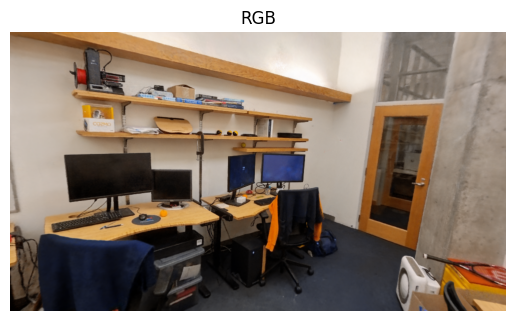

In [4]:
plt.imshow((outputs["rgb"].cpu().numpy() * 255).astype(np.uint8))
plt.title("RGB")
plt.axis("off")
plt.show()

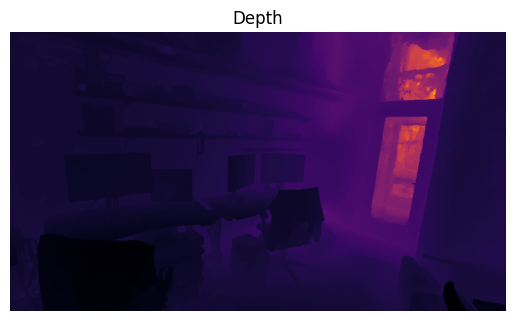

In [5]:
depth = outputs["depth"].squeeze().cpu()
depth_norm = (depth - depth.min()) / (depth.max() - depth.min())

plt.imshow(depth_norm.numpy(), cmap="inferno")
plt.title("Depth")
plt.axis("off")
plt.show()

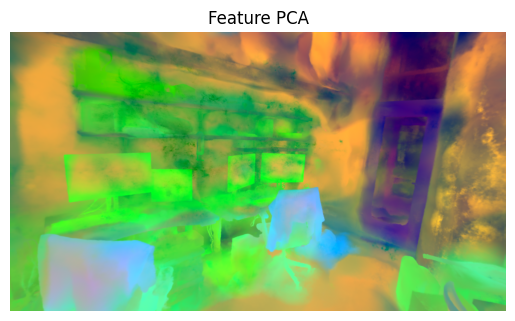

In [6]:
pca_img = outputs["feature_pca"].cpu().numpy()
pca_img = (pca_img - pca_img.min()) / (pca_img.max() - pca_img.min())

plt.imshow(pca_img)
plt.title("Feature PCA")
plt.axis("off")
plt.show()

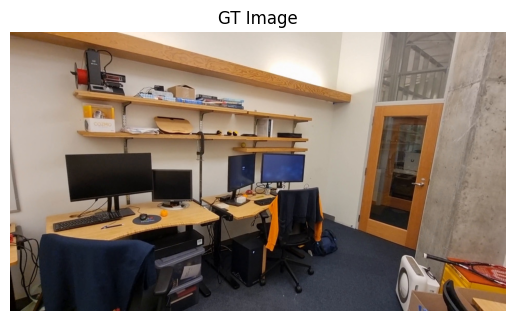

In [7]:
pil_img_gt = Image.open(str(pipeline.datamanager.eval_dataset.image_filenames[eval_idx])).convert("RGB")

plt.imshow(np.array(pil_img_gt))
plt.title("GT Image")
plt.axis("off")
plt.show()

In [8]:
camera_ray_bundle.origins[0][0]   # all origins same, camera center in world coords

tensor([0.3203, 0.1047, 0.0223], device='cuda:0')

In [9]:
for k, v in camera_ray_bundle.__dict__.items():
    print(k, v.shape if hasattr(v, 'shape') else v)

origins torch.Size([540, 960, 3])
directions torch.Size([540, 960, 3])
pixel_area torch.Size([540, 960, 1])
camera_indices torch.Size([540, 960, 1])
nears None
fars None
metadata {'directions_norm': tensor([[[1.5574],
         [1.5560],
         [1.5545],
         ...,
         [1.5606],
         [1.5621],
         [1.5635]],

        [[1.5566],
         [1.5551],
         [1.5537],
         ...,
         [1.5598],
         [1.5612],
         [1.5627]],

        [[1.5557],
         [1.5543],
         [1.5529],
         ...,
         [1.5589],
         [1.5604],
         [1.5618]],

        ...,

        [[1.5354],
         [1.5340],
         [1.5325],
         ...,
         [1.5386],
         [1.5400],
         [1.5415]],

        [[1.5362],
         [1.5347],
         [1.5333],
         ...,
         [1.5393],
         [1.5408],
         [1.5422]],

        [[1.5369],
         [1.5355],
         [1.5341],
         ...,
         [1.5401],
         [1.5415],
         [1.5430]]], device=

In [10]:
num_rays_per_chunk = model.config.eval_num_rays_per_chunk
ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(0, num_rays_per_chunk)
if model.collider is not None:
    ray_bundle = model.collider(ray_bundle)

In [11]:
for k, v in ray_bundle.__dict__.items():
    print(k, v.shape if hasattr(v, 'shape') else v)

origins torch.Size([16384, 3])
directions torch.Size([16384, 3])
pixel_area torch.Size([16384, 1])
camera_indices torch.Size([16384, 1])
nears torch.Size([16384, 1])
fars torch.Size([16384, 1])
metadata {'directions_norm': tensor([[1.5574],
        [1.5560],
        [1.5545],
        ...,
        [1.4585],
        [1.4572],
        [1.4559]], device='cuda:0')}
times None
_shape torch.Size([16384])


In [12]:
ray_samples, weights_list, ray_samples_list = model.proposal_sampler(ray_bundle, density_fns=model.density_fns)

In [13]:
for k, v in ray_samples.frustums.__dict__.items():
    print(k, v.shape if hasattr(v, 'shape') else v)

origins torch.Size([16384, 48, 3])
directions torch.Size([16384, 48, 3])
starts torch.Size([16384, 48, 1])
ends torch.Size([16384, 48, 1])
pixel_area torch.Size([16384, 48, 1])
offsets None
_shape torch.Size([16384, 48])


In [14]:
# 16384 different pixel postions of the original H x W image, each corresponds to a single origin and direction, along with proposal sampler samples 48 (x, y, z) points along the ray at different depths
ray_samples.frustums.get_positions().shape

torch.Size([16384, 48, 3])

In [15]:
field_outputs = model.field.forward(ray_samples, compute_normals=model.config.predict_normals)

In [16]:
from nerfstudio.field_components.field_heads import FieldHeadNames
field_outputs[FieldHeadNames.RGB].shape, field_outputs[FieldHeadNames.DENSITY].shape

(torch.Size([16384, 48, 3]), torch.Size([16384, 48, 1]))

In [17]:
weights = ray_samples.get_weights(field_outputs[FieldHeadNames.DENSITY])
weights.shape

torch.Size([16384, 48, 1])

In [18]:
rgb = model.renderer_rgb(rgb=field_outputs[FieldHeadNames.RGB], weights=weights)
rgb.shape

torch.Size([16384, 3])

In [19]:
depth = model.renderer_depth(weights=weights, ray_samples=ray_samples)
depth.shape

torch.Size([16384, 1])

In [20]:
from f3rm.feature_field import FeatureField, FeatureFieldHeadNames
ff_outputs = model.feature_field(ray_samples)
ff_outputs[FeatureFieldHeadNames.FEATURE].shape

torch.Size([16384, 48, 768])

In [21]:
features = model.renderer_feature(features=ff_outputs[FeatureFieldHeadNames.FEATURE], weights=weights)
features.shape

torch.Size([16384, 768])

In [22]:
# num parameters in field and feature_field
num_params_field = sum(p.numel() for p in model.field.parameters())
num_params_feature_field = sum(p.numel() for p in model.feature_field.parameters())
num_params_field, num_params_feature_field

(12216336, 56320)

# Custom Pose

In [ ]:
from nerfstudio.cameras.cameras import Cameras

# Use intrinsics from eval_dataset (assuming you want similar FOV)
eval_cams = pipeline.datamanager.eval_dataset.cameras
fx, fy = eval_cams.fx[0], eval_cams.fy[0]
cx, cy = eval_cams.cx[0], eval_cams.cy[0]
height, width = eval_cams.height[0], eval_cams.width[0]
dist_params = eval_cams.distortion_params[0]
cam_type = eval_cams.camera_type[0]

In [ ]:
# c2w of a known camera pose
c2w_known = eval_cams.camera_to_worlds[0].cpu().numpy()
# add 4th row for homogeneous coordinates
c2w_known = np.vstack((c2w_known, [0, 0, 0, 1]))
# translate camera 0.5m forward (ie, -0.5 in z in nerfstudio convention) wrt to known cam frame
c2w_delta = Homography.get_std_trans(cz=-0.5)  # this is the known to new transform
c2w_new = c2w_known @ np.linalg.inv(c2w_delta)
c2w_new = c2w_new[:3, :4]  # remove the last row
c2w_new = torch.from_numpy(c2w_new).float().to(model.device)[None, ...]

In [ ]:
# c2w = torch.eye(4)[None, ...].to(model.device)
# c2w[..., 2, 3] = 0.5
# c2w = c2w[:, :3, :4]  # Remove last row

In [ ]:
c2w_viewer = [-0.8025081587509822,0.5966412403996988,8.326673161838576e-17,0,-0.4149196340756713,-0.5580847736047082,0.7185981069914683,0,0.42874523659091934,0.5766808042959521,0.6954257016872606,0,0.1381675073877709,0.4818906926693194,0.31446781793079853,1]
c2w_viewer = np.array(c2w_viewer).reshape(4, 4).T[:3, :4]  # remove last row
c2w_viewer = torch.from_numpy(c2w_viewer).float().to(model.device)[None, ...]
c2w_viewer.shape

In [ ]:
custom_camera = Cameras(
    fx=fx[None],
    fy=fy[None],
    cx=cx[None],
    cy=cy[None],
    height=height[None],
    width=width[None],
    camera_to_worlds=c2w_viewer,
    distortion_params=dist_params[None],
    camera_type=cam_type[None],
    times=None,
    metadata=None,
).to(model.device)

ray_bundle = custom_camera.generate_rays(camera_indices=0).to(model.device)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle)